# Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import glob
import datetime
import time
import copy

import sys  
sys.path.insert(0, '../')

from soundings.preprocessing import dataloader as dl
from soundings.preprocessing import goesimager as im
from soundings.preprocessing import rtmaloader
from soundings.preprocessing import preprocess
from soundings.utils import radiosonde_products
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT

np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
vol = '/Users/stock/Development/research/soundings/data/subset/'

GOES-16, NWP RAP/HRRR, RTMA, Radiosonde
---

- Radiosonde
    - Date
    - Latitude/Longitude
    - Elevation
    
- RTMA
    - Regional surface values Pressure/Temperature/Dew Point

- NWP
    - Regional model with isobaric values
        - v/u wind component
        - cloud ice
        - temperature
        - dew point
        - specific humidity
        
- GOES-16
    - Regional model capturing bands 8, 9, 10, 11, 13, 14, 15, 16

### Data Organization
$
\begin{align}
X_n  & \\
& G_8 : \text{upper-level water vapor 6.2}\mu m \\
& G_9 : \text{mid-level water vapor 6.9}\mu m \\
& G_{10} : \text{lower-level water vapor 7.3}\mu m \\
& G_{11} : \text{cloud-top phase 8.4}\mu m \\
& G_{13} : \text{clean longwave window 10.3}\mu m \\
& G_{14} : \text{longwave window 11.2}\mu m \\
& G_{15} : \text{dirty longwave window 12.3}\mu m \\
& G_{16} : \text{CO2 longwave 13.3}\mu m \\
& P^s : \text{RTMA Surface Pressure} \\
& T^s : \text{RTMA Surface Temperature} \\
& T_d^s : \text{RTMA Surface Dew Point} \\
& P^n : \text{NWP Pressure, 25 mb increments} \\
& T^n : \text{NWP Temperature} \\
& T_d^n : \text{NWP Dew Point} \\
Y_n  & \\
& T^r : \text{Radiosonde Temperature} \\
& T_d^r : \text{Radiosonde Dew Point} 
\end{align}
$

| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $P^n$ | $T^n$ | $T_d^n$ | ---- | $T^r$ | $T_d^r$ |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:    | :--:  | :---: | :--:    | ---- | :--:  | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 1000  | 31.2  | 22.2    | ---- | 31.6  | 21.9    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 995   | 31.5  | 21.9    | ---- | 31.2  | 21.4    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 990   | 30.3  | 20.5    | ---- | 30.8  | 20.6    |
...


| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $T_{1000}^n$ | $T_{d 1000}^n$ | $T_{995}^n$ | $T_{d 995}^n$ | ... | ---- | $T_{1000}^r$ | $T_{d 1000}^r$ | $T_{995}^r$ | $T_{d 995}^r$ | ... |
|:-------------:| :--: | :--: | :--: | :--:  | :--:  | :--: | :---: | :--: | :---: | :--: | :--: | ---- | :--: | :--: | :--: | :--: | :--: |
|2019-09-12-0300| 40.2 | -95.| ... | 999 | 32.0 | 21.5 | 31.2 | 22.2 | 31.2 | 22.2 | ... | ---- | 31.6 | 21.9 | 31.6 | 21.9 | ... |

In [3]:
def add_input(D, inputs, key):
    x_cord, y_cord = dl.lat_lon_point(D, inputs['lat'], inputs['lon'])
    try:
        inputs[key] = D['data'][x_cord][y_cord]
    except:
        print(f'ERROR! Unable to extract value from {f}')
        
def error_msg(model, inputs):
    print(f'ERROR! Unable to get {model} data for sounding. '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

In [4]:
fin = vol + '/radiosonde/20190912.dat'
radiosondes = dl.read_sonde(fin)

interval = 5
ret = None

for i in range(len(radiosondes)):
    
    y = []
    x = []
    
    ## extract SOUNDINGS
    sonde = pd.DataFrame(radiosondes[i]['data']).values
    # interpolate sounding values 
    for j in range(len(sonde) - 1):
        # pressure, temperature, dewpoint
        p1, t1, td1 = sonde[j][1], sonde[j][3], sonde[j][4]
        p2, t2, td2 = sonde[j+1][1], sonde[j+1][3], sonde[j+1][4]
        if p1 == p2:
            continue
        # temperature slope
        mt = (t1-t2)/(p1-p2)
        bt = -mt*p1 + t1
        # dewpoint slope
        mtd = (td1-td2)/(p1-p2)
        btd = -mtd*p1 + td1
        # add new values within interval
        for p in np.arange(p1, p2, -1):
            if p % interval == 0:
                t = mt*p + bt
                td = mtd*p + btd
                y.append({'P_r': p, 'T_r': t, 'Td_r': td})
    
    sonde_meta = radiosondes[i]['metadata']
    date = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                             int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)
    inputs = {}
    inputs['lat'], inputs['lon'] = sonde_meta['LAT'], sonde_meta['LON']
    inputs['date'] = date
    t0 = time.time()
    
    ## extract GOES
    files = sorted(glob.glob(vol + 'goes/' + date.strftime('*%Y%j%H*')))
    if len(files) != 8:
        error_msg('GOES', inputs)
        continue
    for f in files:
        D = dl.read_goes(f)
        add_input(D, inputs, 'G'+str(D['band_id'][0]))
    print(f'GOES took {time.time()-t0}')
    t0 = time.time()
    
    ## extract RTMA
    indicies = {'Pressure': 'P_s', 'Temperature': 'T_s', 'Dew point temperature': 'Td_s'}
    directories = glob.glob(vol + 'rtma/' + date.strftime('*%Y%m%d*/'))
    valid = True
    if len(directories) != 3:
        valid = False
        
    for d in directories:
        files = glob.glob(d + '/' + date.strftime('*%Y%m%d%H*'))
        if len(files) == 0:
            valid = False
            break
        for f in files:
            D = dl.read_rtma(f)
            add_input(D, inputs, indicies[D['name']])
    if not valid:
        error_msg('RTMA', inputs)
        continue
    print(f'RTMA took {time.time()-t0}')
    t0 = time.time()
    
    ## extract NWP RAP
    files = glob.glob(vol + 'nwp_model/' + date.strftime('*rap_*%Y%m%d_%H*'))
    if len(files) == 0:
        error_msg('NWP', inputs)
        continue
    for f in files:
        Ds = dl.read_nwp(f)[::-1]
        x_cord, y_cord = dl.lat_lon_point(Ds[0], inputs['lat'], inputs['lon'])
        for j in range(len(Ds) - 1):
            # pressure, temperature
            p1, t1 = Ds[j]['level'], Ds[j]['data'][x_cord][y_cord]
            p2, t2 = Ds[j+1]['level'], Ds[j+1]['data'][x_cord][y_cord]
            if p1 == p2:
                continue
            # temperature slope
            mt = (t1-t2)/(p1-p2)
            bt = -mt*p1 + t1
            # add new values within interval
            for p in np.arange(p1, p2, -1):
                if p % interval == 0:
                    t = mt*p + bt
                    inputs['P_n'] = p
                    inputs['T_n'] = t -273.15
                    x.append(copy.copy(inputs))
    print(f'NWP took {time.time()-t0}')

    join = pd.DataFrame(x).join(pd.DataFrame(y).set_index('P_r'), on='P_n').dropna()
    if ret is None:
        ret = join
    else:
        ret.append(join)
        
    print(f'INFO! Appended sounding data for '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

ERROR! Unable to get GOES data for sounding. 2020-09-12 14:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 16:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 20:00:00+00:00, 32.5, -114.0
GOES took 8.018509149551392
RTMA took 1.7383151054382324
NWP took 2.242191791534424
INFO! Appended sounding data for 2019-09-12 19:00:00+00:00, 41.6, -90.57
ERROR! Unable to get GOES data for sounding. 2019-09-12 15:00:00+00:00, 28.48, -80.55


In [8]:
ret.to_csv(vol + '/preprocessed.csv', index=False)

In [9]:
ret.head()

,lat,lon,date,G8,G9,G10,G11,G13,G14,G15,G16,P_s,T_s,Td_s,P_n,T_n,T_r,Td_r
3,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,985,30.051764,30.755556,21.644444
4,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,980,29.679932,29.200000,21.200000
5,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,975,29.308099,28.800000,21.081818
6,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,970,28.853162,28.400000,20.963636
7,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,965,28.398224,28.000000,20.845455


In [20]:
fin = vol + '/radiosonde/US_25Jun2019.cdf'
dataset = xr.open_dataset(fin, decode_times=False)

profile, metadata = dl.read_radiosonde_launch(dataset, 0)

In [24]:
profile.shape

(256, 5)

In [21]:
interpolate_dim = 256
soundings = np.zeros((dataset.dims['recNum'], interpolate_dim, 5))
soundings.shape

(172, 256, 5)

In [51]:
dataset

<xarray.Dataset>
Dimensions:   (mTropNum: 4, mWndNum: 5, manLevel: 22, recNum: 172, sigTLevel: 250, sigWLevel: 150)
Dimensions without coordinates: mTropNum, mWndNum, manLevel, recNum, sigTLevel, sigWLevel
Data variables:
    wmoStat   (recNum) float64 7.003e+04 7.003e+04 ... 9.128e+04 9.128e+04
    wbanStat  (recNum) int32 27502 27502 27502 27502 ... 22536 22536 21504 21504
    staName   (recNum) |S6 b'BRW   ' b'BRW   ' b'BRW   ' ... b'ITO   ' b'ITO   '
    staLat    (recNum) float32 71.3 71.3 71.3 71.3 ... 21.98 21.98 19.72 19.72
    staLon    (recNum) float32 -156.78 -156.78 -156.78 ... -155.07 -155.07
    staElev   (recNum) float32 12.0 12.0 12.0 12.0 5.0 ... 36.0 36.0 10.0 10.0
    synTime   (recNum) float64 1.561e+09 1.561e+09 ... 1.561e+09 1.561e+09
    numMand   (recNum) int32 15 16 15 15 13 17 17 15 ... 17 12 7 11 16 15 16 16
    numSigT   (recNum) int32 21 29 24 36 63 29 37 60 ... 30 19 22 134 146 87 92
    numSigW   (recNum) int32 48 50 56 51 45 66 71 96 ... 60 15 50 48 53 86 101
    numMwnd   (recNum) int32 0 0 0 0 0 0 0 0 0 1 0 0 ... 1 0 0 0 0 0 0 0 0 0 0 0
    numTrop   (recNum) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 2 0 1 2 1 1 1
    relTime   (recNum) float64 1.561e+09 1.561e+09 ... 1.561e+09 1.561e+09
    sondTyp   (recNum) int32 99999 99999 99999 99999 ... 99999 99999 99999 99999
    prMan     (recNum, manLevel) float32 1022.0 1000.0 ... 9.96921e+36
    htMan     (recNum, manLevel) float32 12.0 184.0 ... 9.96921e+36 9.96921e+36
    tpMan     (recNum, manLevel) float32 274.8 271.7 ... 9.96921e+36 9.96921e+36
    tdMan     (recNum, manLevel) float32 1.6 0.1 3.5 ... 9.96921e+36 9.96921e+36
    wdMan     (recNum, manLevel) float32 35.0 30.0 ... 9.96921e+36 9.96921e+36
    wsMan     (recNum, manLevel) float32 6.2 6.2 4.1 ... 9.96921e+36 9.96921e+36
    prSigT    (recNum, sigTLevel) float32 1017.0 965.0 ... 9.96921e+36
    htSigT    (recNum, sigTLevel) float32 51.0 466.0 ... 9.96921e+36 9.96921e+36
    tpSigT    (recNum, sigTLevel) float32 272.9 269.7 ... 9.96921e+36
    tdSigT    (recNum, sigTLevel) float32 0.5 0.2 ... 9.96921e+36 9.96921e+36
    wdSigT    (recNum, sigTLevel) float32 nan nan ... 9.96921e+36 9.96921e+36
    wsSigT    (recNum, sigTLevel) float32 nan nan ... 9.96921e+36 9.96921e+36
    prSigW    (recNum, sigWLevel) float32 985.0 947.8 ... 9.96921e+36
    htSigW    (recNum, sigWLevel) float32 304.0 609.0 ... 9.96921e+36
    tpSigW    (recNum, sigWLevel) float32 nan nan ... 9.96921e+36 9.96921e+36
    tdSigW    (recNum, sigWLevel) float32 nan nan ... 9.96921e+36 9.96921e+36
    wdSigW    (recNum, sigWLevel) float32 30.0 30.0 ... 9.96921e+36 9.96921e+36
    wsSigW    (recNum, sigWLevel) float32 5.7 5.1 ... 9.96921e+36 9.96921e+36
    prTrop    (recNum, mTropNum) float32 284.0 9.96921e+36 ... 9.96921e+36
    htTrop    (recNum, mTropNum) float32 9468.0 9.96921e+36 ... 9.96921e+36
    tpTrop    (recNum, mTropNum) float32 222.7 9.96921e+36 ... 9.96921e+36
    tdTrop    (recNum, mTropNum) float32 7.0 9.96921e+36 ... 9.96921e+36
    wdTrop    (recNum, mTropNum) float32 325.0 9.96921e+36 ... 9.96921e+36
    wsTrop    (recNum, mTropNum) float32 18.5 9.96921e+36 ... 9.96921e+36
    prMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
    htMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
    tpMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
    tdMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
    wdMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
    wsMaxW    (recNum, mWndNum) float32 9.96921e+36 9.96921e+36 ... 9.96921e+36
Attributes:
    comment0:  First mandatory level is surface level
    version:   Forecast Systems Lab 1.3

In [62]:
for i in range(dataset.dims['recNum']):
    profile, _ = dl.read_radiosonde_launch(dataset, i)
    soundings[i,:,:] = profile
np.save(vol + 'preprocessed_US_25Jun2019.npy', soundings)

In [42]:
!rm /Users/stock/Development/research/soundings/data/subset/preprocessed_US_25Jun2019.nc
# ncfile = Dataset(vol + 'preprocessed_US_25Jun2019.nc', mode='w', format='NETCDF4') 
# ncfile.createDimension('launches', dataset.dims['recNum'])
# ncfile.createDimension('sounding_dims', interpolate_dim)
# radiosonde_P = ncfile.createVariable('radiosonde_P', np.float64, ('launches', 'sounding_dims'))
# radiosonde_P.units = 'hPa'
# radiosonde_P.long_name = 'radiosonde pressure'

## GOES 16

In [7]:
# Iterative soln to only read a single days 
# worth of goes abi for a given sonde
im.extract_abi_patches(vol + 'radiosonde/US_25Jun2019.cdf', vol + 'goes', vol + 'processed',
                       patch_x_length_pixels=28, patch_y_length_pixels=28,
                       time_range_minutes=5, bt=False)

0 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
1 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
2 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
3 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
4 Central Lon (-165.430) and Lat (64.500) does not exist in GOES-16 projection.
5 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
6 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
7 Central Lon (-155.620) and Lat (62.970) does not exist in GOES-16 projection.
8 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
9 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
10 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
11 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
12 Central Lon (-170.220) and Lat (57.

0

In [80]:
fin = vol + '../raobs/arm-sgp/2019/sgpsondewnpnC1.b1.20190624.203400.cdf'
raob = xr.open_dataset(fin)
date = raob.time.values[0]
# raob.close()

print(date)

2019-06-24T20:34:00.000000000


In [84]:
raob

<xarray.Dataset>
Dimensions:      (time: 3124)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-24T20:34:00 ... 2019-06-24T21:26:03
Data variables:
    base_time    datetime64[ns] 2019-06-24
    time_offset  (time) datetime64[ns] 2019-06-24T20:34:00 ... 2019-06-24T21:26:03
    qc_time      (time) int32 0 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
    pres         (time) float32 975.67 975.11 974.43 974.0 ... 69.38 69.35 69.33
    qc_pres      (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    tdry         (time) float32 28.2 27.6 27.42 27.29 ... -58.71 -58.68 -58.66
    qc_tdry      (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    dp           (time) float32 11.78 10.5 10.35 10.2 ... -89.59 -89.56 -89.54
    qc_dp        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    wspd         (time) float32 1.3 0.8 0.9 1.0 1.0 1.0 ... 8.1 8.1 8.1 8.0 8.0
    qc_wspd      (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    deg          (time) float32 213.0 301.0 315.0 319.0 ... 294.0 294.0 294.0
    qc_deg       (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    rh           (time) float32 36.0 34.24 34.27 34.19 ... 1.06 1.06 1.06 1.06
    qc_rh        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    u_wind       (time) float32 0.70803064 0.6857339 ... 7.3083634 7.3083634
    qc_u_wind    (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    v_wind       (time) float32 1.0902717 -0.41203034 ... -3.2538934 -3.2538934
    qc_v_wind    (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    wstat        (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    asc          (time) float32 0.0 4.6 6.2 3.9 3.9 6.8 ... 4.3 6.3 6.0 5.4 7.0
    qc_asc       (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    lat          (time) float32 36.61 36.610004 36.61 ... 36.696857 36.696827
    lon          (time) float32 -97.49 -97.48999 ... -96.84085 -96.84077
    alt          (time) float32 314.8 319.8 326.0 ... 18812.6 18818.0 18825.0
Attributes:
    command_line:               sonde_ingest -s sgp -f C1
    process_version:            ingest-sonde-10.12-0.el6
    ingest_software:            ingest-sonde-10.12-0.el6
    dod_version:                sondewnpn-b1-2.1
    site_id:                    sgp
    facility_id:                C1: Lamont, Oklahoma
    data_level:                 b1
    input_source:               /data/collection/sgp/sgpsondeC1.00/good.2019J...
    resolution_description:     The resolution field attributes refer to the ...
    sample_int:                 1.2 seconds
    averaging_int:              None
    pressure_correction:        1.0
    temperature_correction:     -9999.0
    humidity_correction:        -9999.0
    humidity_correction_2:      -9999.0
    launch_mode:                nominal mode
    launch_status:              
\n/// SGPC1/MW41
\n474646
\n190624 2034
\n R...
    pressure_gc_sonde:          974.7
    temperature_gc_sonde:       -9999.0
    humidity_gc_sonde:          -9999.0
    humidity_gc_sonde_2:        -9999.0
    latitude_calculation:       lat[k-1]+((v_wind[k]-v_wind[k-1])/2)*delta_ti...
    longitude_calculation:      lon[k-1]+((u_wind[k]-u_wind[k-1])/2)*delta_ti...
    sonde_pc_software_version:  2.40
    sounding_number:            ///
    serial_number:              R1110476
    qc_standards_version:       1.0
    qc_method:                  Standard Mentor QC
    qc_comment:                 The QC field values are a bit packed represen...
    qc_bit_1_description:       Value is equal to missing_value.
    qc_bit_1_assessment:        Bad
    qc_bit_2_description:       Value is less than the valid_min.
    qc_bit_2_assessment:        Bad
    qc_bit_3_description:       Value is greater than the valid_max.
    qc_bit_3_assessment:        Bad
    qc_bit_4_description:       Difference between current and previous value...
    qc_bit_4_assessm

In [78]:
center_lon, center_lat = -109.6825, 23.3666
x_size_pixels, y_size_pixels = 100, 100

goes16 = im.GOES16ABI(vol + 'goes', date)
patch, lons, lats = goes16.extract_image_patch(center_lon, center_lat, x_size_pixels, y_size_pixels, bt=True)

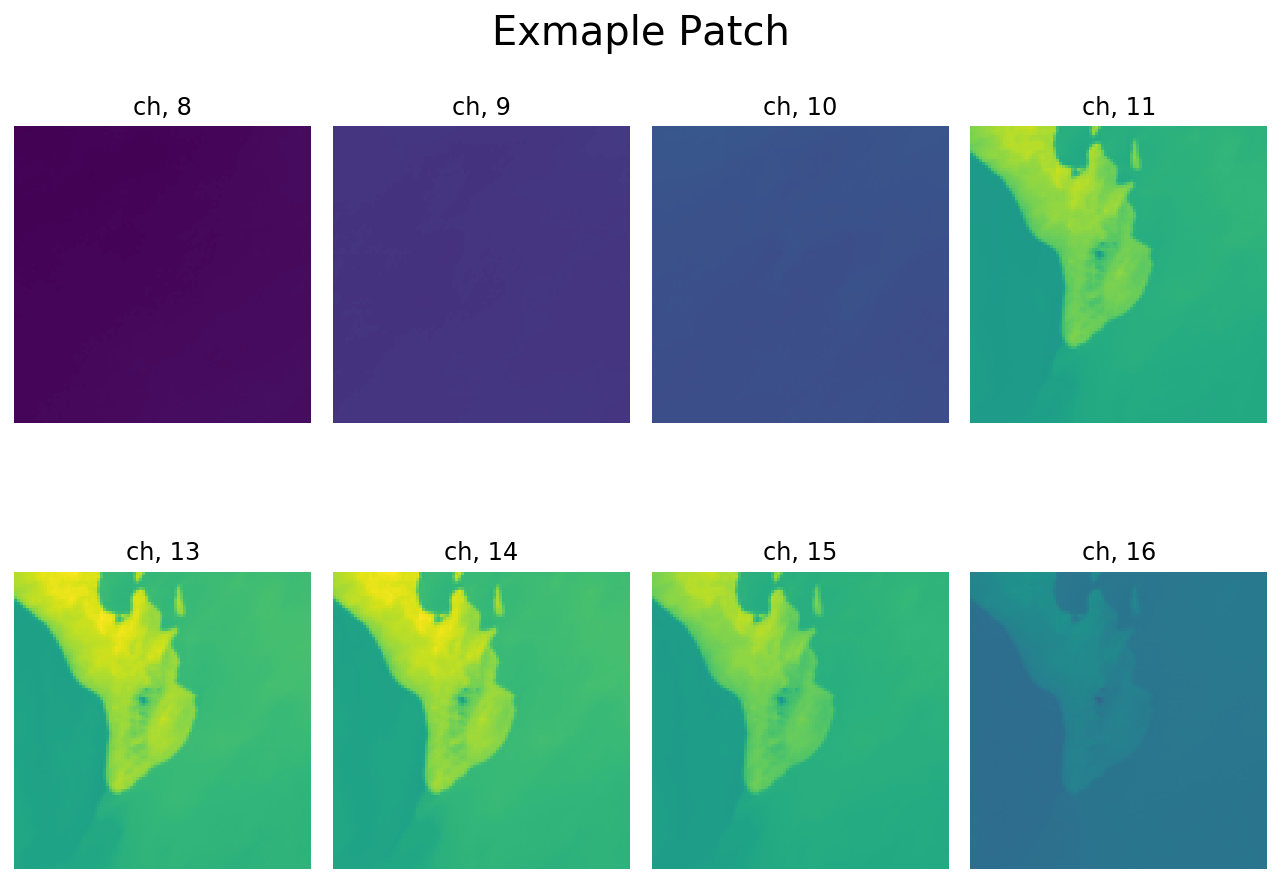

In [79]:
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(goes16.bands[i])}')
fig.tight_layout()

In [3]:
# process all of the soundings for the 
sonde_config = {'sonde_profile_dims': 256}
goes_config = {'bands': np.array([8, 9, 10, 11, 13, 14, 15, 16]), 
              'patch_x_length_pixels': 28,
              'patch_y_length_pixels': 28,
              'abi_path': vol + 'goes',
              'time_range_minutes': 5,
              'bt': False}
preprocess.set_configs(sonde_config, goes_config)
preprocess.extract_all_information(vol)

0 Invalid sounding time: 2019-06-24 23:01:00+00:00 lon: -156.780 lat: 71.300
1 Invalid sounding time: 2019-06-25 05:30:00+00:00 lon: -156.780 lat: 71.300
2 Invalid sounding time: 2019-06-25 11:01:00+00:00 lon: -156.780 lat: 71.300
3 Invalid sounding time: 2019-06-25 17:30:00+00:00 lon: -156.780 lat: 71.300
4 Invalid sounding time: 2019-06-24 23:27:00+00:00 lon: -165.430 lat: 64.500
5 Invalid sounding time: 2019-06-24 23:01:00+00:00 lon: -161.800 lat: 60.780
6 Invalid sounding time: 2019-06-25 11:01:00+00:00 lon: -161.800 lat: 60.780
7 Invalid sounding time: 2019-06-24 23:09:00+00:00 lon: -155.620 lat: 62.970
8 Invalid sounding time: 2019-06-24 23:02:00+00:00 lon: -147.870 lat: 64.820
9 Invalid sounding time: 2019-06-25 11:03:00+00:00 lon: -147.870 lat: 64.820
10 Invalid sounding time: 2019-06-24 23:03:00+00:00 lon: -150.020 lat: 61.170
11 Invalid sounding time: 2019-06-25 11:02:00+00:00 lon: -150.020 lat: 61.170
12 Invalid sounding time: 2019-06-24 23:50:00+00:00 lon: -170.220 lat: 57.

In [8]:
xar = xr.open_dataset(vol + '/processed/abi_patches_TEST.nc')

In [11]:
xar.abi.values.shape

(1, 8, 28, 28)

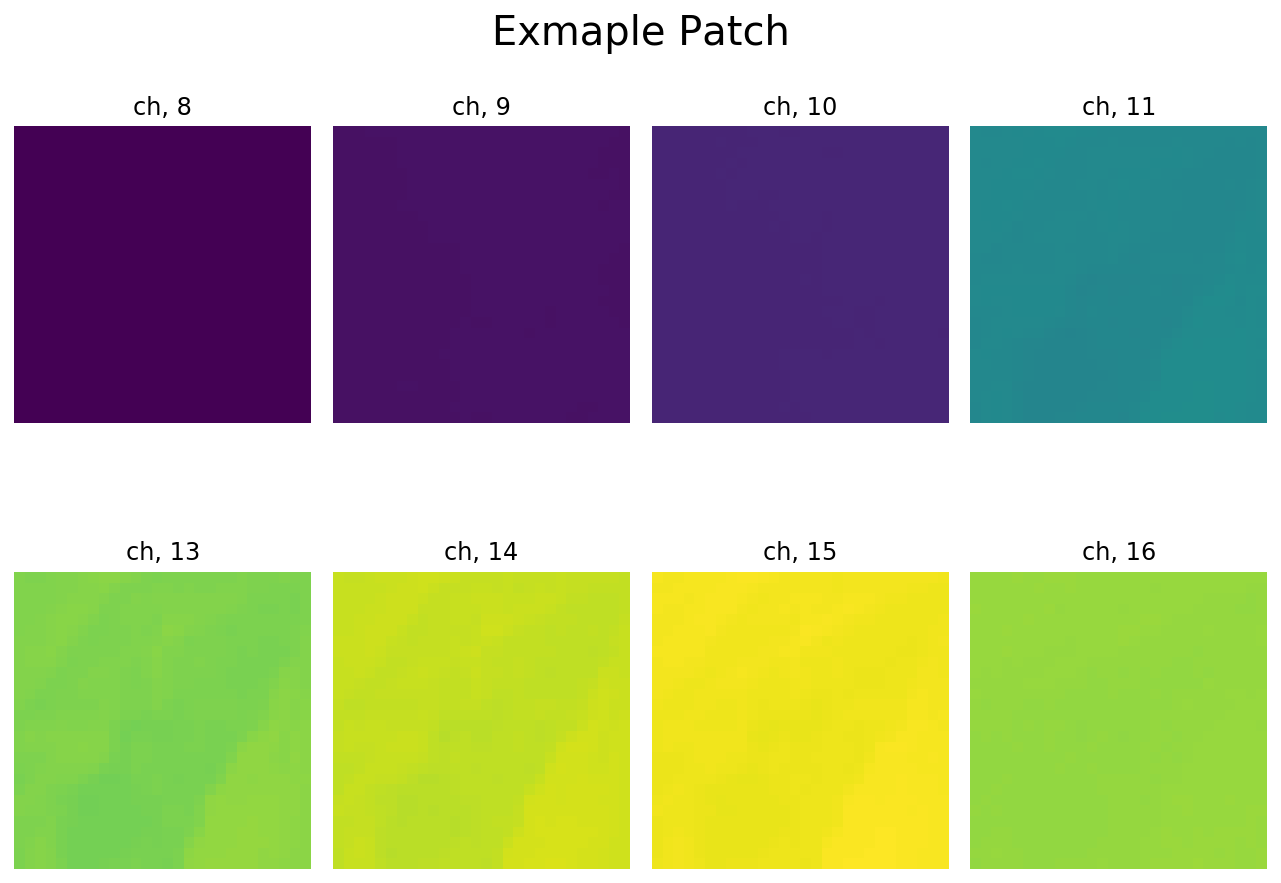

In [4]:
patch = xar.goes_abi.values
index = 1
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(xar.band.values[i])}')
fig.tight_layout()

# RTMA

In [15]:
fin = vol + '../raobs/arm-sgp/2019/sgpsondewnpnC1.b1.20190624.203400.cdf'
raob = xr.open_dataset(fin)
date = raob.time.values[0]
raob.close()

print(date)

2019-06-24T20:34:00.000000000


In [86]:
center_lon, center_lat = -109.6825, 23.3666
x_size_pixels, y_size_pixels = 100, 100

rtma = rtmaloader.RTMALoader(vol + 'rtma', date)

patch, lons, lats = rtma.extract_image_patch(center_lon, center_lat, x_size_pixels, y_size_pixels)

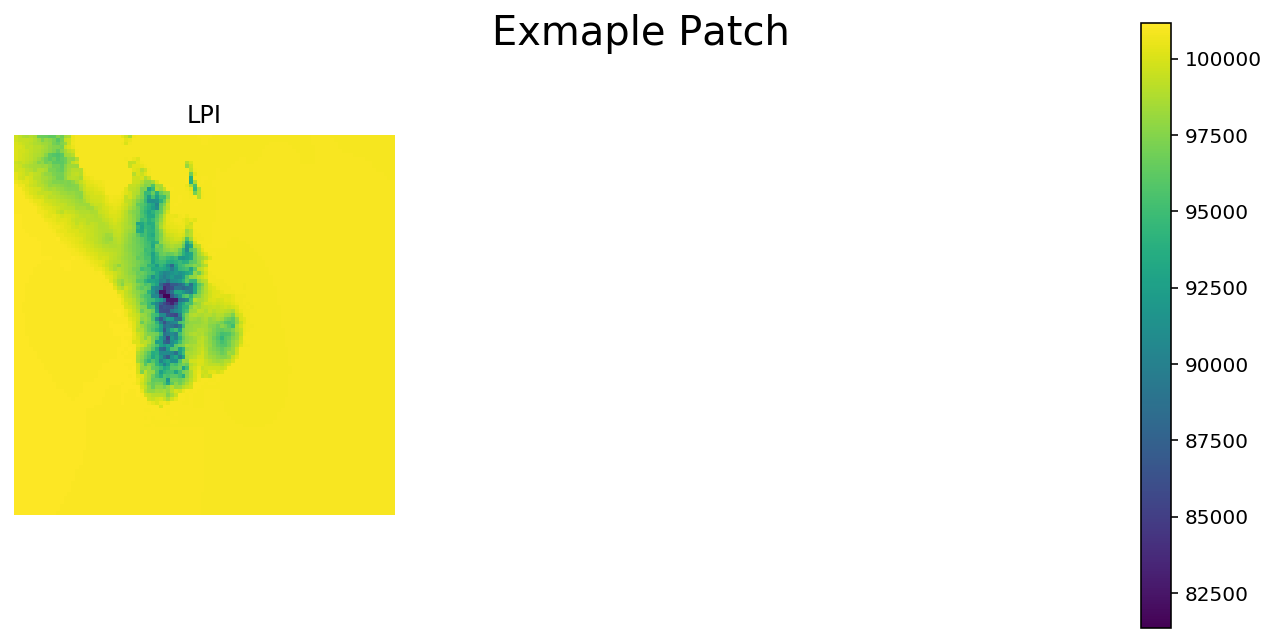

In [88]:
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(1, 3, figsize=(9, 4.5))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    im = axs[i].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[i].set_title(f'{str(rtma.rtma_types[i])}')
    break
fig.tight_layout()

In [121]:
isinstance([12], np.ndarray)

False

In [128]:
# process all of the soundings for the 
sonde_config = {'sonde_profile_dims': 2048,
                'alt_el': 21_000}
goes_config = {'bands': np.array([8, 9, 10, 11, 13, 14, 15, 16]), 
              'patch_x_length_pixels': 28,
              'patch_y_length_pixels': 28,
              'abi_path': vol + 'goes',
              'time_range_minutes': 5,
              'bt': False}
rtma_config = {'patch_x_length_pixels': 28,
               'patch_y_length_pixels': 28,
               'rtma_type': np.array(['LPI']),
               'path': vol + 'rtma',
               'time_range_minutes': 30}
preprocess.set_configs(sonde_config, goes_config, rtma_config)
preprocess.extract_all_information(vol + '../')

(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 02:31:00+00:00.nc
(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 05:35:00+00:00.nc
(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 14:26:00+00:00.nc
(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 20:34:00+00:00.nc
ERROR: No LPI RTMA files within 30 minutes of 2019-06-25 23:31:00. Nearest file is within 31.000 minutes
(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 08:33:00+00:00.nc
(28, 28)
/Users/stock/Development/research/soundings/data/subset/../processed/2019-06-25 11:25:00+00:00.nc
runtime: 4.479994773864746


---
# Misc

In [55]:
sounding_dict = dict()
sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.sonde_profile_P.values[index]
sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.sonde_profile_T.values[index]
sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.sonde_profile_Td.values[index]

In [66]:
radiosonde_products.surface_based_cape_cin(sounding_dict)

(2023.905889349416, -101.55760642758013)

In [60]:
radiosonde_products.most_unstable_cape_cin(sounding_dict)

(2571.6940645766363, -11.010678054471661)

In [83]:
import metpy.calc

el_pressures, el_temperatures = 0, 0
n = 0

for i in xar.sample.values:
    sounding_dict = dict()
    sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.sonde_profile_P.values[i]
    sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.sonde_profile_T.values[i]
    sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.sonde_profile_Td.values[i]
    el_pressure, el_temperature = radiosonde_products.el(sounding_dict)
    
    if not np.isnan(el_pressure):
        el_pressures += el_pressure
        el_temperatures += el_temperature
        n += 1.
        
print(el_pressures/n, el_temperature/n)

380.8878119529115 nan


moist lapse rate in pressure coordinates
$$\frac{dT}{dP} = \Big(\frac{1}{P}\Big) \frac{R_d T + L_v r_s}{C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}} : b = 1$$

dry lapse rate in pressure coordinates
$$\frac{dT}{dP} = \frac{b R_d T}{C_{pd} P}$$

(100, 2) (100, 1) (2, 1)


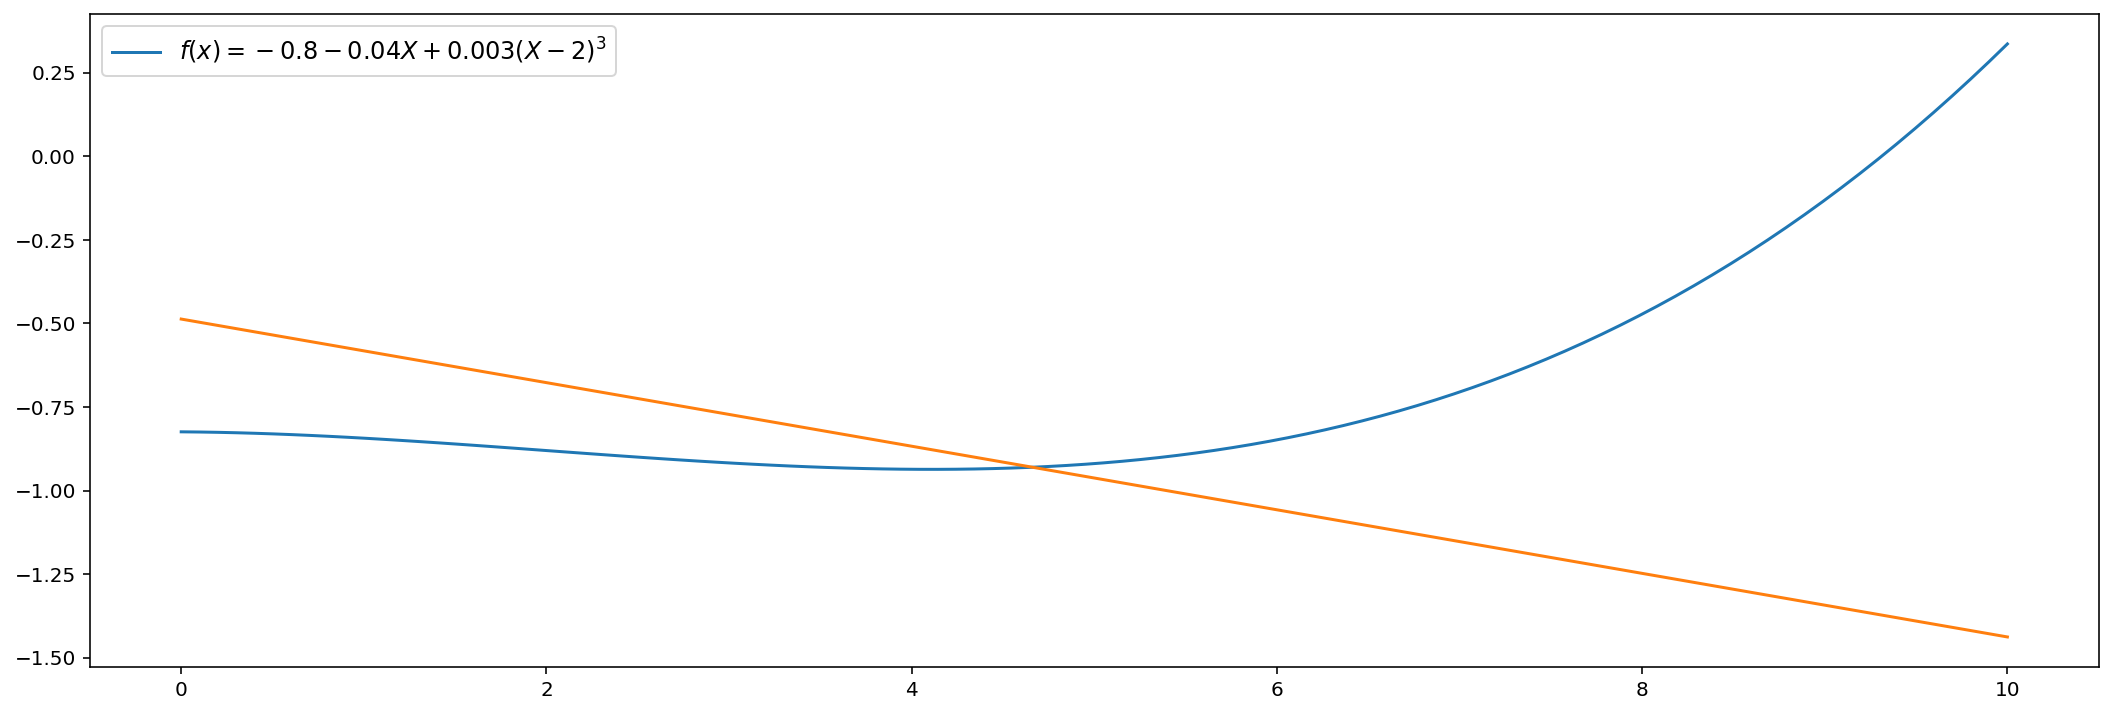

In [82]:
n_samples = 100
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = -0.8 - 0.04 * X  + 0.003 * (X - 2)**3
X = np.insert( X, 0, 1, axis=1 )
w = np.random.uniform(-1, 1, (X.shape[1], 1 ))
print(X.shape, T.shape, w.shape)

plt.figure(figsize=(18, 6))
plt.plot(X[:,1], T, label="$f(x) = -0.8 - 0.04 X + 0.003 (X - 2)^3$")
plt.plot(X[:,1], X @ w)
plt.legend(loc='best', fontsize=12);